## Assignment 3 Pattern Mining and Recommender Systems: Individual Code

### Task 2: Collaborative Filtering

### Ky Cuong Pham, 1906313

# 0. Exploratory Data Analysis (EDA)

In this session, we have done:

- Loaded and cleaned the dataset by removing empty entries.  
- Converted data types for consistency.  
- Explored the basic structure of the data including the number of unique users, items, and total transactions.  
- Plot item popularity
- Check for any patterns over time
- Calculated user-item interaction matrix sparsity for appropriate modeling


In [51]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import random
import warnings

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from surprise import Reader, SVD, accuracy
from surprise import Dataset as SurpriseDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from wordcloud import WordCloud
from collections import Counter
from itertools import combinations

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Ignore warnings
warnings.filterwarnings("ignore")

In [36]:
# Load the data
data = pd.read_csv("data/Groceries data train.csv")
data = data.dropna()

# Convert columns to appropriate types
data['User_id'] = data['User_id'].astype('int')
data['year'] = data['year'].astype('int')
data['month'] = data['month'].astype('int')
data['day'] = data['day'].astype('int')
data['day_of_week'] = data['day_of_week'].astype('int')

data.head()

,User_id,Date,itemDescription,year,month,day,day_of_week
0,2351,1/01/2014,cleaner,2014,1,1,2
1,2226,1/01/2014,sausage,2014,1,1,2
2,1922,1/01/2014,tropical fruit,2014,1,1,2
3,2943,1/01/2014,whole milk,2014,1,1,2
4,1249,1/01/2014,citrus fruit,2014,1,1,2


In [37]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 19382 entries, 0 to 19381
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User_id          19382 non-null  int64 
 1   Date             19382 non-null  object
 2   itemDescription  19382 non-null  object
 3   year             19382 non-null  int64 
 4   month            19382 non-null  int64 
 5   day              19382 non-null  int64 
 6   day_of_week      19382 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.2+ MB


,User_id,year,month,day,day_of_week
count,19382.000000,19382.000000,19382.000000,19382.000000,19382.000000
mean,3009.050769,2014.057012,6.166134,15.391342,3.023785
std,1158.135945,0.231871,3.572992,8.750628,1.994446
min,1000.000000,2014.000000,1.000000,1.000000,0.000000
25%,1998.000000,2014.000000,3.000000,8.000000,1.000000
50%,3015.500000,2014.000000,6.000000,15.000000,3.000000
75%,4025.000000,2014.000000,9.000000,23.000000,5.000000
max,5000.000000,2015.000000,12.000000,31.000000,6.000000


Initial insights:
- Contains 19,382 grocery transactions.  
- Data spans across the years 2014 to 2015.  
- User IDs range from 1000 to 5000.  
- Transactions are distributed across all months and days of the week.  

In [38]:
print(data['User_id'].nunique(), "unique users")
print(data['itemDescription'].nunique(), "unique items")
print(data.shape[0], "total transactions")

3493 unique users
167 unique items
19382 total transactions


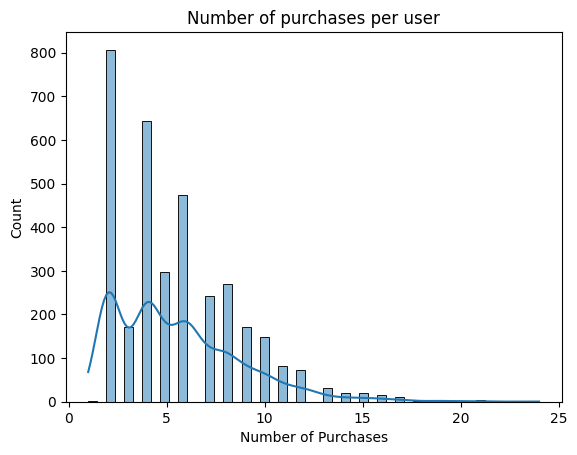

In [39]:
# Purchases per user
user_counts = data['User_id'].value_counts()
sns.histplot(user_counts, bins=50, kde=True)
plt.title("Number of purchases per user")
plt.xlabel("Number of Purchases")
plt.show()

- Most users made a small number of purchases (less than 10)
- The distribution is **left-skewed**

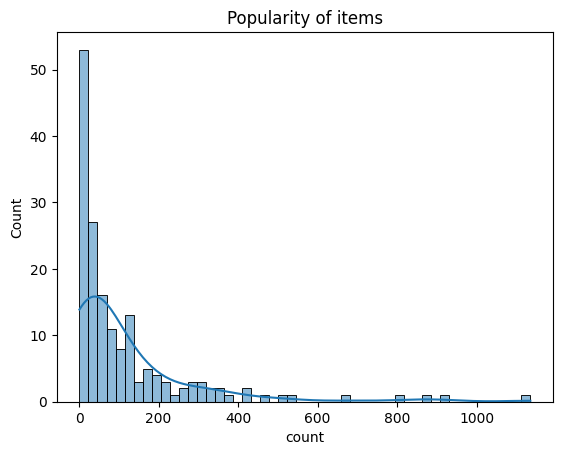

In [40]:
# Item popularity
item_counts = data['itemDescription'].value_counts()
sns.histplot(item_counts, bins=50, kde=True)
plt.title("Popularity of items")
plt.show()

The distribution of item purchases is **left-skewed**, indicating that a few items are purchased frequently -> suggesting **PATTERNS**

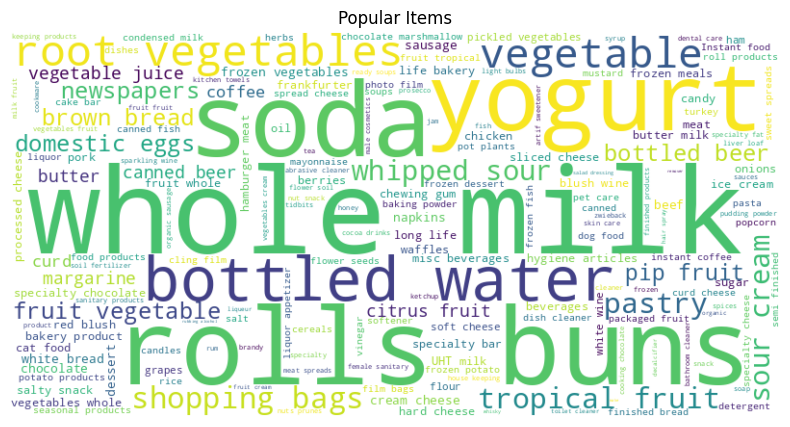

In [41]:


# 1-gram (single words) word cloud
text = ' '.join(data['itemDescription'].dropna().astype(str))
wordcloud_1gram = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot 1-gram word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1gram, interpolation='bilinear')
plt.axis('off')
plt.title("Popular Items")
plt.show()

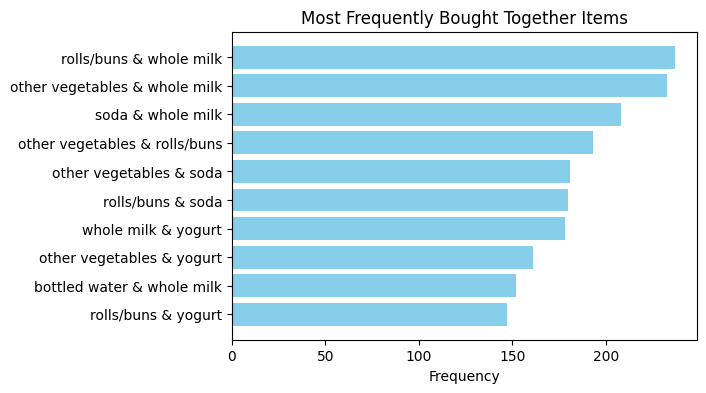

In [42]:
transaction_groups = data.groupby('User_id')['itemDescription'].apply(list)

# Generate 2-item combinations (pairs) for each transaction
item_pairs = []
for items in transaction_groups:
    item_pairs.extend(combinations(sorted(set(items)), 2))  # Create unique pairs

# Count the frequency of each item pair
pair_counts = Counter(item_pairs)

# Get the most common item pairs
top_pairs = pair_counts.most_common(10) 

# Extract the item pairs and their counts for plotting
pairs, counts = zip(*top_pairs)
pairs = [' & '.join(pair) for pair in pairs]

plt.figure(figsize=(6, 4))
plt.barh(pairs, counts, color='skyblue') 
plt.xlabel("Frequency")
plt.title("Most Frequently Bought Together Items")
plt.gca().invert_yaxis()  
plt.show()

# 1. Data preprocessing
In this section, we have done:
- Split data into train a test set (80/20)
- Add new column `purchase` to indicate implicite feedback

In [43]:
data['purchase'] = 1  # implicit feedback

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (15505, 8)
Test data shape: (3877, 8)


# 2. Memory based approach
This approach implements user-based collaborative filtering, where items are recommended based on the preferences of similar users. In order to do that, the process is the followings (Tomasevic, Paunovic & Vranes 2019):
- Calculate the similarity between users using **cosine similarity** 
- Recommend items that similar users bought, weighted by the degree of similarity between users

In [44]:
user_item_matrix = train_data.groupby(['User_id', 'itemDescription']).size().unstack(fill_value=0)
print("User-item matrix shape:", user_item_matrix.shape) #  (number of users, number of items)
user_item_matrix.head()


User-item matrix shape: (3461, 167)


itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
User_id,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


In [45]:
 # Calculate cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(
    user_similarity,
    index=user_item_matrix.index,
    columns=user_item_matrix.index
)

user_similarity_df.head()

User_id,1000,1001,1002,1003,1004,1005,1006,1009,1010,1011,...,4988,4989,4990,4991,4992,4993,4995,4997,4999,5000
User_id,,,,,,,,,,,,,,,,,,,,,
1000,1.000000,0.000000,0.000000,0.000000,0.147442,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1001,0.000000,1.000000,0.188982,0.169031,0.315244,0.218218,0.308607,0.0,0.000000,0.188982,...,0.000000,0.267261,0.0,0.104828,0.000000,0.169031,0.0,0.000000,0.000000,0.000000
1002,0.000000,0.188982,1.000000,0.000000,0.312772,0.000000,0.204124,0.0,0.000000,0.000000,...,0.288675,0.353553,0.0,0.416025,0.000000,0.000000,0.0,0.000000,0.250000,0.250000
1003,0.000000,0.169031,0.000000,1.000000,0.279751,0.258199,0.182574,0.0,0.000000,0.223607,...,0.000000,0.316228,0.0,0.248069,0.000000,0.400000,0.0,0.000000,0.223607,0.000000
1004,0.147442,0.315244,0.312772,0.279751,1.000000,0.240772,0.340503,0.0,0.065938,0.208514,...,0.000000,0.294884,0.0,0.346989,0.085126,0.186501,0.0,0.208514,0.104257,0.104257


In [46]:
# Preview the similarity users
user_id = 1145
n_neighbors = 10  
top_n = 5

# Get similar users (excluding the target user)
user_idx = user_item_matrix.index.get_loc(user_id)
similar_users = user_similarity_df.iloc[user_idx].sort_values(ascending=False)[1:n_neighbors+1]
print(f"Top {n_neighbors} similar users to User {user_id}:")
for sim_user_id, similarity in similar_users.items():
    print(f"User {sim_user_id}: Similarity = {similarity:.3f}")

Top 10 similar users to User 1145:
User 1405: Similarity = 0.816
User 1523: Similarity = 0.775
User 4539: Similarity = 0.667
User 2005: Similarity = 0.667
User 3626: Similarity = 0.667
User 2266: Similarity = 0.667
User 3851: Similarity = 0.667
User 4943: Similarity = 0.667
User 1969: Similarity = 0.655
User 2204: Similarity = 0.655


In [47]:
# Get items that the target user hasn't purchased
user_items = set(user_item_matrix.columns[user_item_matrix.loc[user_id] > 0])
items_to_recommend = set(user_item_matrix.columns) - user_items
print(f"Items not purchased by User {user_id}:  {items_to_recommend}")

Items not purchased by User 1145:  {'chicken', 'skin care', 'specialty chocolate', 'candy', 'decalcifier', 'newspapers', 'specialty bar', 'frozen dessert', 'oil', 'cream cheese ', 'preservation products', 'condensed milk', 'fish', 'kitchen utensil', 'canned fruit', 'jam', 'organic sausage', 'pip fruit', 'beef', 'long life bakery product', 'syrup', 'sausage', 'bags', 'root vegetables', 'rum', 'salad dressing', 'packaged fruit/vegetables', 'baking powder', 'make up remover', 'turkey', 'instant coffee', 'potato products', 'ready soups', 'domestic eggs', 'pickled vegetables', 'rolls/buns', 'rubbing alcohol', 'salty snack', 'male cosmetics', 'whipped/sour cream', 'grapes', 'soft cheese', 'frozen potato products', 'nuts/prunes', 'photo/film', 'dishes', 'snack products', 'shopping bags', 'canned fish', 'sliced cheese', 'baby cosmetics', 'canned beer', 'frozen fruits', 'hamburger meat', 'tropical fruit', 'white bread', 'soda', 'liquor', 'specialty vegetables', 'white wine', 'sweet spreads', 'f

In [48]:
# Calculate recommendation scores
recommendations = {}

for item in items_to_recommend:
    score = 0
    total_similarity = 0
    
    for sim_user_id, similarity in similar_users.items():
        # If similar user has purchased this item
        if user_item_matrix.loc[sim_user_id, item] > 0:
            weight = user_item_matrix.loc[sim_user_id, item]
            score += similarity * weight
            total_similarity += similarity
    
    # Normalize score by total similarity if possible
    if total_similarity > 0:
        recommendations[item] = score / total_similarity # sum(similarity * rating)/sum(similarity)

# Sort recommendations by score
sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)

# Return top N recommendations
sorted_recommendations[:top_n]

[('chicken', 1.0),
 ('oil', 1.0),
 ('long life bakery product', 1.0),
 ('domestic eggs', 1.0),
 ('whipped/sour cream', 1.0)]

Root Mean Squared Error (RMSE) is used in collaborative filtering because it shows the distance between predicted and actual user transactions. It penalizes larger errors, making it effective in measuring accuracy. RMSE can be easily interpreted, as it is in the same units as the data (Jadon 2024). That is why we chose RMSE for this project.

In [49]:
# Evaluate the model using RMSE
# Build user-item interaction matrix from training data
user_item_matrix = train_data.groupby(['User_id', 'itemDescription'])['purchase'].sum().unstack(fill_value=0)

# Cosine similarity (user-user)
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Evaluate on test set
actuals = []
predictions = []
n_neighbors = 10

for _, row in train_data.iterrows():
    user = row['User_id']
    item = row['itemDescription']
    
    # Only evaluate if user and item are in training data
    if user in user_item_matrix.index and item in user_item_matrix.columns:
        user_idx = user_item_matrix.index.get_loc(user)
        similar_users = user_similarity_df.iloc[user_idx].sort_values(ascending=False)[1:n_neighbors+1]
        
        score = 0
        total_sim = 0
        for sim_user_id, similarity in similar_users.items():
            if item in user_item_matrix.columns:
                interaction = user_item_matrix.loc[sim_user_id, item]
                if interaction > 0:
                    score += similarity * interaction
                    total_sim += similarity
        
        predicted = score / total_sim if total_sim > 0 else 0
        predictions.append(predicted)
        actuals.append(1)  # because every row in test_df is an actual purchase

# Compute RMSE
manual_rmse = np.sqrt(mean_squared_error(actuals, predictions))
manual_rmse

0.37327939461493786

# 3. Model based approaches
In this section, we experimented: 
- **SVD (Singular Value Decomposition)**:  
  SVD is a matrix factorization technique that decomposes the user-item interaction matrix into features for users and items. It is effective in capturing the densed infomation about user preferences and item, even with sparse data (Zhang 2022) like our dataset.

- **MLP (Multi-Layer Perceptron)**:  
  MLP is a simple neural network that can compute non-linear relationships between users and items. MLP learns complex patterns and representations directly from data, improving recommendation quality (He et al. 2017).

### SVD

In [57]:
# Reader
reader = Reader(rating_scale=(0, 1))

# Prepare trainset
train_data_surprise = SurpriseDataset.load_from_df(train_data[['User_id', 'itemDescription', 'purchase']], reader)
trainset = train_data_surprise.build_full_trainset()

testset = list(test_data[['User_id', 'itemDescription', 'purchase']].itertuples(index=False, name=None))

svd = SVD()
svd.fit(trainset)

predictions = svd.test(testset)

# Evaluate
svd_rmse = accuracy.rmse(predictions)

# Calculate recommendation scores
recommendations = {}
for item in items_to_recommend:
    # Predict if the user will buy the item
    pred = svd.predict(user_id, item)
    recommendations[item] = pred.est

# Sort recommendations by the predicted score
sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)

# Show the top N recommendations
print(f"Top {top_n} recommendations for User {user_id}:")
for item, score in sorted_recommendations[:top_n]:
    print(f"{item}: Predicted score = {score:.4f}")



RMSE: 0.0419
Top 5 recommendations for User 1145:
skin care: Predicted score = 1.0000
specialty chocolate: Predicted score = 1.0000
candy: Predicted score = 1.0000
decalcifier: Predicted score = 1.0000
preservation products: Predicted score = 1.0000


## MLP

In [53]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# Fit on the full dataset to ensure consistent mapping
data['user'] = user_encoder.fit_transform(data['User_id'])
data['item'] = item_encoder.fit_transform(data['itemDescription'])

train_data['user'] = user_encoder.transform(train_data['User_id'])
train_data['item'] = item_encoder.transform(train_data['itemDescription'])

test_data['user'] = user_encoder.transform(test_data['User_id'])
test_data['item'] = item_encoder.transform(test_data['itemDescription'])

In [54]:
train_interactions = list(zip(train_data['user'], train_data['item'], train_data['purchase']))
test_interactions = list(zip(test_data['user'], test_data['item'], test_data['purchase']))

num_users = data['user'].nunique()
num_items = data['item'].nunique()

In [55]:

class MLPDataset(Dataset):
    def __init__(self, interactions, num_users, num_items, num_negatives=4, is_training=True):
        self.data = []
        self.num_users = num_users
        self.num_items = num_items
        self.interactions_set = set((u, i) for u, i, l in interactions if l == 1)
        
        if is_training:
            for (u, i, label) in interactions:
                self.data.append((u, i, label))
                if label == 1:
                    for _ in range(num_negatives):
                        j = random.randint(0, num_items - 1)
                        while (u, j) in self.interactions_set:
                            j = random.randint(0, num_items - 1)
                        self.data.append((u, j, 0))
        else:
            self.data = interactions

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user, item, label = self.data[idx]
        return torch.tensor(user), torch.tensor(item), torch.tensor(label, dtype=torch.float32)

class MLPRec(nn.Module):
    def __init__(self, num_users, num_items, layers=[64,32,16,8]):
        super(MLPRec, self).__init__()
        self.embedding_user = nn.Embedding(num_users, layers[0] // 2)
        self.embedding_item = nn.Embedding(num_items, layers[0] // 2)
        
        mlp_layers = []
        input_size = layers[0]
        for layer_size in layers[1:]:
            mlp_layers.append(nn.Linear(input_size, layer_size))
            mlp_layers.append(nn.ReLU())
            input_size = layer_size
            
        self.mlp = nn.Sequential(*mlp_layers)
        self.output = nn.Linear(layers[-1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user, item):
        user_emb = self.embedding_user(user)
        item_emb = self.embedding_item(item)
        x = torch.cat([user_emb, item_emb], dim=-1)
        x = self.mlp(x)
        x = self.output(x)
        return self.sigmoid(x).squeeze()


100%|██████████| 100/100 [14:46<00:00,  8.87s/it]


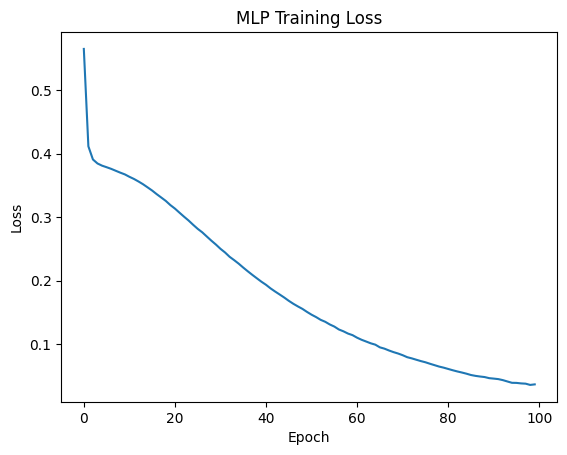

In [324]:

train_dataset = MLPDataset(train_interactions, num_users, num_items, num_negatives=4, is_training=True)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

model = MLPRec(num_users, num_items)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

epochs = 100

history = []
for epoch in tqdm(range(epochs)):
    model.train()
    total_loss = 0
    for user, item, label in train_loader:
        optimizer.zero_grad()
        output = model(user, item)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    history.append(avg_loss)

#plot the training loss
plt.plot(history)
plt.title("MLP Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [325]:
model.eval()
true_labels = []
pred_scores = []

with torch.no_grad():
    for (u, i, l) in test_interactions: # user, item, label
        user_tensor = torch.tensor([u])
        item_tensor = torch.tensor([i])
        pred = model(user_tensor, item_tensor).item()
        pred_scores.append(pred)
        true_labels.append(l)

mlp_rmse = np.sqrt(mean_squared_error(true_labels, pred_scores))
print(f"Test RMSE: {mlp_rmse:.4f}")


Test RMSE: 0.7575


In [56]:
def get_ranked_items_for_user_mlp(user_id: int, model, num_items: int, item_encoder, user_encoder, top_n=None):
    model.eval()

    # Remap the original user ID to the encoded user ID
    encoded_user_id = user_encoder.transform([user_id])[0]
    
    # Generate recommendations for this user
    item_tensor = torch.arange(num_items)
    user_tensor = torch.full_like(item_tensor, fill_value=encoded_user_id)

    with torch.no_grad():
        scores = model(user_tensor, item_tensor).numpy()

    ranked = sorted(zip(item_tensor.numpy(), scores), key=lambda x: x[1], reverse=True)

    # Decode item IDs back to original item descriptions
    decoded_ranked = []
    for item_id, score in ranked:
        decoded_item_id = item_encoder.inverse_transform([item_id])[0]  # Decode item ID to original description
        decoded_item_description = decoded_item_id  # Assuming item ID corresponds to itemDescription directly
        decoded_ranked.append((user_id, decoded_item_id, decoded_item_description, score))

    return decoded_ranked[:top_n] if top_n else decoded_ranked


In [327]:
ranked_items = get_ranked_items_for_user_mlp(user_id, model, num_items, item_encoder, user_encoder, top_n=5)

print(f"Top 5 recommendations for User ID {user_id}:")
for decoded_user_id, item_id, item_description, score in ranked_items:
    print(f"User: {decoded_user_id} | Item: {item_description} (ID: {item_id}) - score = {score:.4f}")


Top 5 recommendations for User ID 1145:
User: 1145 | Item: dessert (ID: dessert) - score = 1.0000
User: 1145 | Item: sausage (ID: sausage) - score = 1.0000
User: 1145 | Item: pastry (ID: pastry) - score = 1.0000
User: 1145 | Item: flour (ID: flour) - score = 1.0000
User: 1145 | Item: cream cheese  (ID: cream cheese ) - score = 1.0000


### Model approaches evaluation

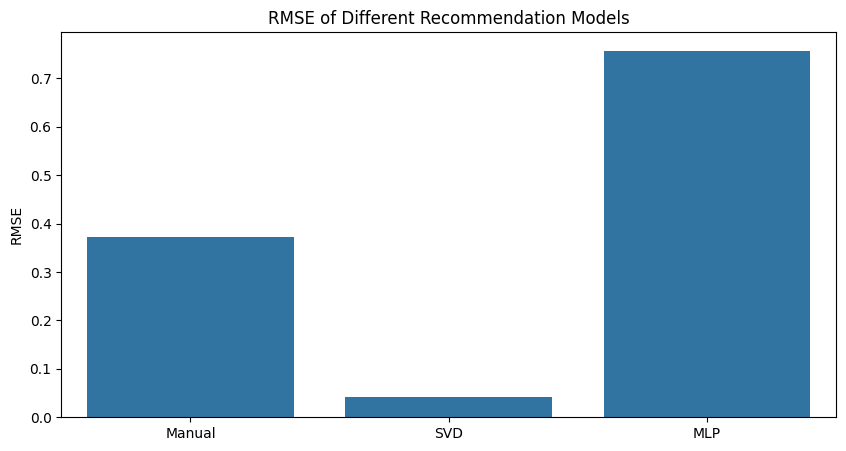

In [328]:
#Plot the final RMSE of manual_rmse, svd_rmse and mlp_rmse
rmse_values = [manual_rmse, svd_rmse, mlp_rmse]
rmse_labels = ['Manual', 'SVD', 'MLP']
plt.figure(figsize=(10, 5))
sns.barplot(x=rmse_labels, y=rmse_values)
plt.ylabel('RMSE')
plt.title('RMSE of Different Recommendation Models')
plt.show()

With RMSE at **0.0419** Matrix factorization (***SVD***) is chosen for collaborative filtering tasks

# 5. Final module

In [330]:
class CFRecommender:
    def __init__(self, data_path):
        self.data_path = data_path
        self.svd = SVD()
        
        self.train()
        
    def load_df(self):
        df = pd.read_csv(self.data_path)
        df = df.dropna()
        df['User_id'] = df['User_id'].astype('int')
        df['year'] = df['year'].astype('int')
        df['month'] = df['month'].astype('int')
        df['day'] = df['day'].astype('int')
        
        self.df = df
        
    def preprocess_df(self):
        # Implicit feedback
        self.df['purchase'] = 1
        
        # Split into train and test sets 80/20
        train_df, test_df = train_test_split(self.df, test_size=0.2, random_state=42)
        self.train_df = train_df
        self.test_df = test_df
        
        # Prepare data for SVD
        reader = Reader(rating_scale=(0, 1))
        train_data_surprise = Dataset.load_from_df(train_data[['User_id', 'itemDescription', 'purchase']], reader)
        self.trainset = train_data_surprise.build_full_trainset()
        self.testset = list(test_data[['User_id', 'itemDescription', 'purchase']].itertuples(index=False, name=None))
        
    def train(self):
        self.load_df()
        self.preprocess_df()
        
        self.svd.fit(self.trainset)
        
    def handle_cold_start(self, top_n=5): # New user
        # Return most frequently bought items
        popular_items = self.train_df['itemDescription'].value_counts().index[:top_n]
        return [(item, 0.0) for item in popular_items]
        
    def evaluate(self):
        return accuracy.rmse(self.svd.test(self.testset))
    
    def recommend(self, user_id, use_patterns=False, top_n=5):
        if user_id not in self.train_df['User_id'].unique():
            print(f"Cold start for User ID {user_id}")
            return self.handle_cold_start(top_n)

        user_items = set(self.train_df[self.train_df['User_id'] == user_id]['itemDescription'])
        all_items = set(self.train_df['itemDescription'].unique())
        items_to_recommend = all_items - user_items

        # Collaborative Filtering Predictions
        recommendations = {}
        for item in items_to_recommend:
            try:
                pred = self.svd.predict(user_id, item)
                recommendations[item] = pred.est
            except:
                continue

        sorted_cf_recs = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)

        if not use_patterns:
            return sorted_cf_recs[:top_n]

        # MOCKED frequent-pattern fallback (replace with your actual pattern engine)
        pattern_based = self.mock_pattern_based(user_items)
        for item, score in pattern_based:
            if item not in user_items and item not in recommendations:
                recommendations[item] = score

        final_sorted = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
        return final_sorted[:top_n]

    def mock_pattern_based(self, user_items):
        # Simulated rules: if user buys 'sugar' → recommend 'milk'
        rules = {
            'sugar': [('milk', 0.7)],
            'flour': [('eggs', 0.6)],
            'ketchup': [('mayonnaise', 0.5)],
        }
        recs = []
        for item in user_items:
            if item in rules:
                recs.extend(rules[item])
        return recs

recommender = CFRecommender("data/Groceries data train.csv")

while True:
    user_input = input("\nEnter User ID (or 'exit'): ").strip()
    if user_input.lower() == 'exit':
        break
    if not user_input.isdigit():
        print("Invalid User ID.")
        continue

    user_id = int(user_input)

    pattern_input = input("Use frequent patterns? (yes/no): ").strip().lower()
    use_patterns = pattern_input == 'yes'

    recommendations = recommender.recommend(user_id, use_patterns, top_n=5)
    print("======================================================")
    print(f"Top 5 recommendations for User ID {user_id} ({'with' if use_patterns else 'without'} patterns):")
    for item, score in recommendations:
        print(f"{item}: Score = {score:.4f}")          

Top 5 recommendations for User ID 1435 (with patterns):
hamburger meat: Score = 1.0000
mayonnaise: Score = 1.0000
artif. sweetener: Score = 1.0000
specialty vegetables: Score = 1.0000
preservation products: Score = 1.0000


# References
* Tomasevic, N, Paunovic, D & Vranes, S 2019, *User-based collaborative filtering approach for content recommendation in OpenCourseWare platforms*, arXiv.org, viewed 26 April 2025, <https://arxiv.org/abs/1902.10376>.
* Jadon, A 2024, *A Comprehensive Survey of Evaluation Techniques for Recommendation Systems*.
* Zhang, Y 2022, *An Introduction to Matrix factorization and Factorization Machines in Recommendation System, and Beyond*, arXiv.org.
* He, X, Liao, L, Zhang, H, Nie, L, Hu, X & Chua, T-S 2017, ‘Neural Collaborative Filtering’, arXiv:1708.05031 [cs].